In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv("OpenSSH_2k.log_structured.csv")
print(df.head())
print(df.info())


   LineId Date  Day      Time Component    Pid  \
0       1  Dec   10  06:55:46     LabSZ  24200   
1       2  Dec   10  06:55:46     LabSZ  24200   
2       3  Dec   10  06:55:46     LabSZ  24200   
3       4  Dec   10  06:55:46     LabSZ  24200   
4       5  Dec   10  06:55:46     LabSZ  24200   

                                             Content EventId  \
0  reverse mapping checking getaddrinfo for ns.ma...     E27   
1         Invalid user webmaster from 173.234.31.186     E13   
2  input_userauth_request: invalid user webmaster...     E12   
3      pam_unix(sshd:auth): check pass; user unknown     E21   
4  pam_unix(sshd:auth): authentication failure; l...     E19   

                                       EventTemplate  
0  reverse mapping checking getaddrinfo for <*> [...  
1                          Invalid user <*> from <*>  
2  input_userauth_request: invalid user <*> [prea...  
3      pam_unix(sshd:auth): check pass; user unknown  
4  pam_unix(sshd:auth): authentication 

**Descriptive analysis**

Columns: ['LineId', 'Date', 'Day', 'Time', 'Component', 'Pid', 'Content', 'EventId', 'EventTemplate']

Data types:
 LineId            int64
Date             object
Day               int64
Time             object
Component        object
Pid               int64
Content          object
EventId          object
EventTemplate    object
dtype: object

Missing values (%):
 LineId           0.0
Date             0.0
Day              0.0
Time             0.0
Component        0.0
Pid              0.0
Content          0.0
EventId          0.0
EventTemplate    0.0
dtype: float64

Top EventId values:
 EventId
E24    413
E20    384
E9     383
E10    135
E21    135
E13    113
E12    113
E19    110
E27     85
E7      45
Name: count, dtype: int64

Sample log lines:


0    reverse mapping checking getaddrinfo for ns.ma...
1           Invalid user webmaster from 173.234.31.186
2    input_userauth_request: invalid user webmaster...
3        pam_unix(sshd:auth): check pass; user unknown
4    pam_unix(sshd:auth): authentication failure; l...
Name: Content, dtype: object

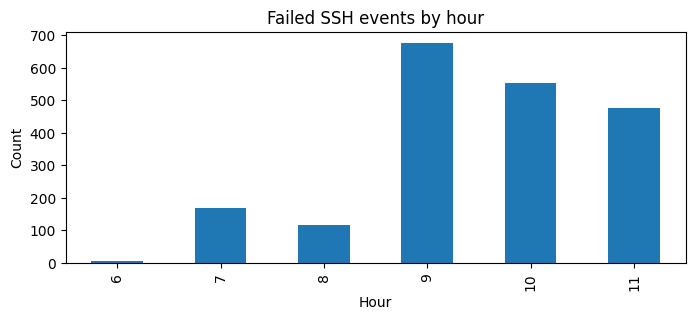


FailureType distribution:
 FailureType
Other                745
Disconnected         471
Failed password      385
Invalid user         365
Connection closed     34
Name: count, dtype: int64

Top 10 source IPs:
 Ip
183.62.140.253     867
187.141.143.180    349
103.99.0.122       172
112.95.230.3        80
5.188.10.180        53
185.190.58.151      43
123.235.32.19       22
52.80.34.196        15
60.2.12.12          15
103.207.39.212      12
Name: count, dtype: int64

Top 10 targeted users:
 User
unknown           135
admin              87
authentication     45
support            18
oracle             18
test               15
user               12
0                  10
1234                9
guest               9
Name: count, dtype: int64

Distinct EventId count: 27


,EventId,Ip,User,FailureType
0,E27,173.234.31.186,NaN,Other
1,E13,173.234.31.186,webmaster,Invalid user
2,E12,NaN,webmaster,Invalid user
3,E21,NaN,unknown,Other
4,E19,173.234.31.186,NaN,Other
5,E10,173.234.31.186,webmaster,Invalid user
6,E2,173.234.31.186,NaN,Connection closed
7,E2,212.47.254.145,NaN,Connection closed
8,E13,52.80.34.196,test9,Invalid user
9,E12,NaN,test9,Invalid user


In [2]:
# --- Basic stats ---
print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values (%):\n", (df.isna().mean()*100).round(2).sort_values(ascending=False))

print("\nTop EventId values:\n", df["EventId"].value_counts().head(10))
print("\nSample log lines:")
display(df["Content"].head(5))

# --- Some data on Time column ---
if "Time" in df.columns:
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S", errors="coerce")
    df["Hour"] = df["Time"].dt.hour
    ax = df["Hour"].value_counts().sort_index().plot(kind="bar", figsize=(8,3))
    ax.set_title("Failed SSH events by hour")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Count")
    plt.show()

df["Ip"]   = df["Content"].str.extract(r'(\d{1,3}(?:\.\d{1,3}){3})')
df["User"] = df["Content"].str.extract(r'\buser\s+(\w+)\b', flags=re.IGNORECASE)


def detect_failure_type(msg: str) -> str:
    m = str(msg).lower()
    if "invalid user" in m:      return "Invalid user"
    if "failed password" in m:   return "Failed password"
    if "connection closed" in m: return "Connection closed"
    if "disconnect" in m:        return "Disconnected"
    if "error" in m:             return "Other error"
    return "Other"

df["FailureType"] = df["Content"].apply(detect_failure_type)

# --- STATS ---
print("\nFailureType distribution:\n", df["FailureType"].value_counts())
print("\nTop 10 source IPs:\n", df["Ip"].value_counts().head(10))
print("\nTop 10 targeted users:\n", df["User"].value_counts().head(10))
print("\nDistinct EventId count:", df["EventId"].nunique())

df[["EventId","Ip","User","FailureType"]].head(10)


**Implementation of the Necessary Preprocessing**

In [3]:
import re
import pandas as pd
import numpy as np


if "Time" in df.columns:
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S", errors="coerce")
    df["Hour"] = df["Time"].dt.hour
else:

    if "Hour" not in df.columns:
        df["Hour"] = -1


#ajout de colonnes
df["ip"] = df["Content"].str.extract(r'(\d{1,3}(?:\.\d{1,3}){3})')
df["user"] = df["Content"].str.extract(r'\buser\s+(\w+)\b', flags=re.IGNORECASE)
df["port"] = df["Content"].str.extract(r'\bport\s+(\d+)\b').astype(float)  # temporary float to handle NaN
df["preauth"] = df["Content"].str.contains(r"\[preauth\]", case=False, na=False)
df["conn_per_hour"] = df.groupby(["ip", "Hour"])["ip"].transform("count")


# Clean
df["user"] = df["user"].fillna("unknown")
df["ip"]   = df["ip"].fillna("0.0.0.0")
df["port"] = df["port"].fillna(0).astype(int)
df["conn_per_hour"]   = df["conn_per_hour"].fillna(0).astype(int) #pour les ip inconnues







#classification des evenement en 2 catégories "normal" et "Suspect"
normal_events = {"E1", "E2", "E22", "E23", "E24", "E25", "E26"}
df["connection_type"] = df["EventId"].apply(lambda x: "N" if str(x) in normal_events else "S")

#EventId nous as servi pour classifier les connexions en normales et suspectes, pour avoir 2classes au lieu de 26, on
#a donc plus besoin de cette colonne
#la colonne content a été decoupee en plusieurs colonnes plus lisibles, nous n'avons plus besoin de cette colonne non plus mais gardons la pour plus tard
cols_to_keep = ["ip", "user", "port", "preauth", "Hour", "conn_per_hour", "connection_type",'Content']
df = df[[c for c in cols_to_keep if c in df.columns]].copy()

print(df.head(10))
print("\nconnection_type distribution:\n", df["connection_type"].value_counts())


               ip       user   port  preauth  Hour  conn_per_hour  \
0  173.234.31.186    unknown      0    False     6              5   
1  173.234.31.186  webmaster      0    False     6              5   
2         0.0.0.0  webmaster      0     True     6              0   
3         0.0.0.0    unknown      0    False     6              0   
4  173.234.31.186    unknown      0    False     6              5   
5  173.234.31.186  webmaster  38926    False     6              5   
6  173.234.31.186    unknown      0     True     6              5   
7  212.47.254.145    unknown      0     True     7              1   
8    52.80.34.196      test9      0    False     7              6   
9         0.0.0.0      test9      0     True     7              0   

  connection_type                                            Content  
0               S  reverse mapping checking getaddrinfo for ns.ma...  
1               S         Invalid user webmaster from 173.234.31.186  
2               S  input_us

#Problematique

Chaques jours, les systèmes informatiques enregistre de nombreuses connexion et stockent les informations les concernant dans des journaux que l'on appel "Log". Certaines de ces connexions peuvent correspondre à des tentatives d'accès non autorisées, et les annalyser peut donc permettre de renforcer la sécurité des systèmes pour detecter les comportements suspects.

Dans ce projet, nous allons donc analyser des logs d'authentification SSH afin de détecter des activités anormales, comm les tentatices répétées de connexion.

Notre jeu de données contient de nombreuses informations qui ne nous serons pas utile comme le Pid (inutile car toutes les connexions ont été enregistrées sur la meme machine) et dont nous nous sommes donc débarassé. La colonne "Content" contenait quand à elle de nombreuses informations mais innexploitable car sous forme de texte, nous l'avons donc éclatée en plusieurs colonnes comme "IP". Enfin nous avons calculer le nombre de connexion d'un Ip par heure pour reperer les tentatives repétées et nous avons classifier les differents event (type d'échec ou de réussite de connexion) en deux categorie Suspect "S" ou Normal "N".


**Selection and Implementation of a Baseline Model**

Binary baseline (Normal vs Suspect)

=== Binary Classification (Normal vs Suspect) ===
              precision    recall  f1-score   support

           N      1.000     1.000     1.000        92
           S      1.000     1.000     1.000       308

    accuracy                          1.000       400
   macro avg      1.000     1.000     1.000       400
weighted avg      1.000     1.000     1.000       400



c:\Users\Andr3\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


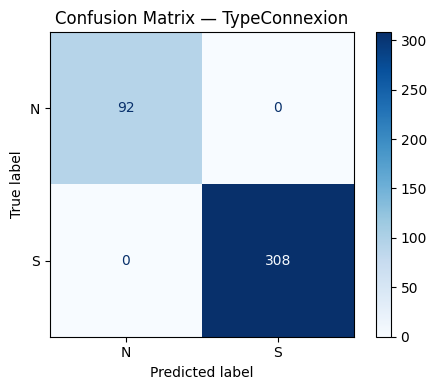

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Définition X / y ===
y_bin = df["connection_type"] #colonne à prédire
X_bin = df.drop(columns=["connection_type",'Content'])  # toutes les autres colonnes pour predire connection_type

# different traitement selon le type de colonne
num_cols  = ["port","Hour", "conn_per_hour"] 
bool_cols = ["preauth"]
cat_cols  = ["ip", "user"]   # mots donc on va les encoder avec one-hot encoding pour qu'ils soient utilisables par le modèle (transformation en variables numériques)

# Préprocessing
prepro = ColumnTransformer([
    ("num",  "passthrough", num_cols),
    ("bool", "passthrough", bool_cols),
    ("cat",  OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols) #encodage
])

# Pipeline
model = Pipeline([
    ("prep", prepro),
    ("LR", LogisticRegression(max_iter=300))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.20, random_state=42, stratify=y_bin
)

# Entraînement
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

print("=== Binary Classification (Normal vs Suspect) ===")
print(classification_report(y_test, y_pred, digits=3))

# Matrice de confusion
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — TypeConnexion")
plt.tight_layout()
plt.show()


Notre model est trop parfais: aucun faux negatif ou  faux positif, il doit y avoir une variable trop corrélée a connexion type, ce qui donne directement la réponse au model et l'empèche d'apprendre. C'est tres probablement "ip": les ips de notre réseau sont considérées comme normale et les autres comme suspectes. Verifions ça, en regardant si certaines ips ont 100% N et d'autres 100% S. Si c'est le cas nous allons enlever IP des colonnes a utiliser pour predire connexion type

In [5]:
print(df.groupby(["ip","connection_type"]).size().head(50))


ip               connection_type
0.0.0.0          N                    2
                 S                  264
1.237.174.253    N                    3
103.207.39.16    N                    3
                 S                    9
103.207.39.165   N                    1
                 S                    4
103.207.39.212   N                    3
                 S                    9
103.99.0.122     S                  172
104.192.3.34     N                    2
                 S                    5
106.5.5.195      S                    4
112.95.230.3     N                   26
                 S                   54
119.137.62.142   N                    2
119.4.203.64     S                    9
123.235.32.19    N                    7
                 S                   15
173.234.31.186   N                    2
                 S                    8
175.102.13.6     N                    1
                 S                    3
177.79.82.136    S                    1
181.214

Certaines IP apparaissent uniquement en S (ex : 103.99.0.122 → 172 fois S) et certaines IP apparaissent quasiment toujours dans la même classe

Le modèle a donc appris :
“Si IP = X → répondre S. Si IP = Y → répondre N.”

recomençons sans cette colonne

=== Binary Classification (Normal vs Suspect) ===
              precision    recall  f1-score   support

           N      0.989     0.989     0.989        92
           S      0.997     0.997     0.997       308

    accuracy                          0.995       400
   macro avg      0.993     0.993     0.993       400
weighted avg      0.995     0.995     0.995       400



c:\Users\Andr3\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


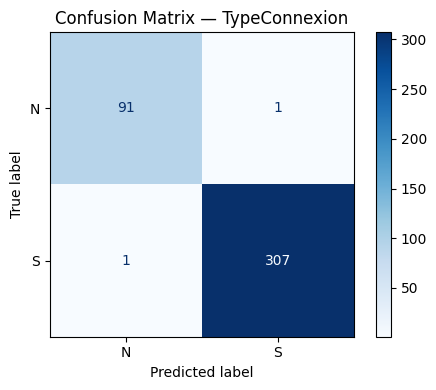

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Définition X / y ===
y_bin = df["connection_type"] #colonne à prédire
X_bin = df.drop(columns=["connection_type", "Content","ip"])  # toutes les autres colonnes pour predire connection_type

# different traitement selon le type de colonne
num_cols  = ["port","Hour", "conn_per_hour"] 
bool_cols = ["preauth"]
cat_cols  = ["user"]   # mots donc on va les encoder avec one-hot encoding pour qu'ils soient utilisables par le modèle (transformation en variables numériques)

# Préprocessing
prepro = ColumnTransformer([
    ("num",  "passthrough", num_cols),
    ("bool", "passthrough", bool_cols),
    ("cat",  OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols) #encodage
])

# Pipeline
model = Pipeline([
    ("prep", prepro),
    ("LR", LogisticRegression(max_iter=300))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.20, random_state=42, stratify=y_bin
)

# Entraînement
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

print("=== Binary Classification (Normal vs Suspect) ===")
print(classification_report(y_test, y_pred, digits=3))

# Matrice de confusion
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — TypeConnexion")
plt.tight_layout()
plt.show()


Notre model est un peu plus réaliste mais il reste tres facile a prédire, surment également grace a user (user = "root" ou "admin": souven t suspect, user = "unknown": suspect, user = "sysadmin" ou "service": normal), enlevons également cette colonne

=== Binary Classification (Normal vs Suspect) ===
              precision    recall  f1-score   support

           N      0.943     0.902     0.922        92
           S      0.971     0.984     0.977       308

    accuracy                          0.965       400
   macro avg      0.957     0.943     0.950       400
weighted avg      0.965     0.965     0.965       400



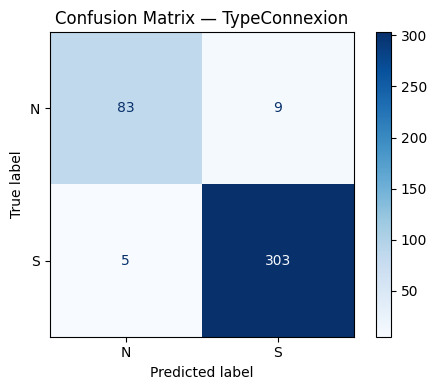

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Définition X / y ===
y_bin = df["connection_type"] #colonne à prédire
X_bin = df.drop(columns=["connection_type", "Content","ip",'user'])  # toutes les autres colonnes pour predire connection_type

# different traitement selon le type de colonne
num_cols  = ["port","Hour", "conn_per_hour"] 
bool_cols = ["preauth"]

# Préprocessing
prepro = ColumnTransformer([
    ("num",  "passthrough", num_cols),
    ("bool", "passthrough", bool_cols),
])

# Pipeline
model = Pipeline([
    ("prep", prepro),
    ("LR", LogisticRegression(max_iter=300))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.20, random_state=42, stratify=y_bin
)

# Entraînement
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

print("=== Binary Classification (Normal vs Suspect) ===")
print(classification_report(y_test, y_pred, digits=3))

# Matrice de confusion
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — TypeConnexion")
plt.tight_layout()
plt.show()


maintenant notre model est beaucoup plus réaliste

Multiclass baseline (FailureType)

                   precision    recall  f1-score   support

Connection closed       0.86      0.86      0.86         7
     Disconnected       0.99      0.98      0.98        94
  Failed password       1.00      1.00      1.00        77
     Invalid user       1.00      1.00      1.00        73
            Other       0.99      1.00      1.00       149

         accuracy                           0.99       400
        macro avg       0.97      0.97      0.97       400
     weighted avg       0.99      0.99      0.99       400



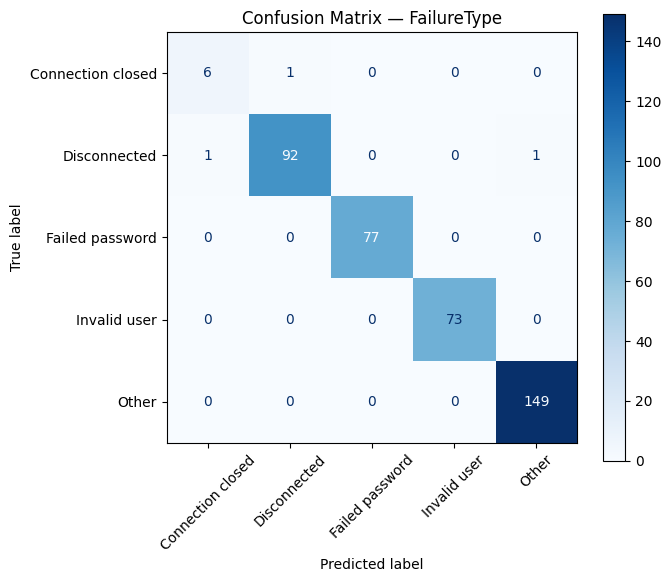

In [24]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# 1. Labels
def detect_failure_type(text):
    t = str(text).lower()
    if "invalid user" in t:      return "Invalid user"
    if "failed password" in t:   return "Failed password"
    if "connection closed" in t: return "Connection closed"
    if "disconnect" in t:        return "Disconnected"
    if "error" in t:             return "Other error"
    return "Other"

df["FailureType"] = df["Content"].apply(detect_failure_type) #creation de la colonne FailureType a partir de la colonne Content

num_cols = ["port", "Hour", "conn_per_hour"]
cat_cols = ["ip","user"]
bool_cols = ["preauth"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("bool", "passthrough", bool_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols) #encodage
])

clf2 = Pipeline([
    ("preproc", preprocessor),
    ("svm", LinearSVC(max_iter=500))
])

X = df.drop(columns=["Content", "FailureType"]) #est il possible de predire FailureType a partir des autres colonnes?
y = df["FailureType"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

#matrice de confusion
fig, ax = plt.subplots(figsize=(7,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix — FailureType")
plt.tight_layout()
plt.show()


notre model est assez precis, on arrive a predire la nature de l'incident uniquement a partir de donnée de base, meme si certaines catégorie sont assez evidentes comme connection close et disconnected qui peuvent etre facilement deduites de preaut ou invalid user de user, si on retire user nos données deviennent un peu plus interessantes

                   precision    recall  f1-score   support

Connection closed       0.86      0.86      0.86         7
     Disconnected       0.99      0.98      0.98        94
  Failed password       0.91      0.88      0.89        77
     Invalid user       0.82      0.58      0.68        73
            Other       0.86      1.00      0.92       149

         accuracy                           0.89       400
        macro avg       0.89      0.86      0.87       400
     weighted avg       0.89      0.89      0.89       400



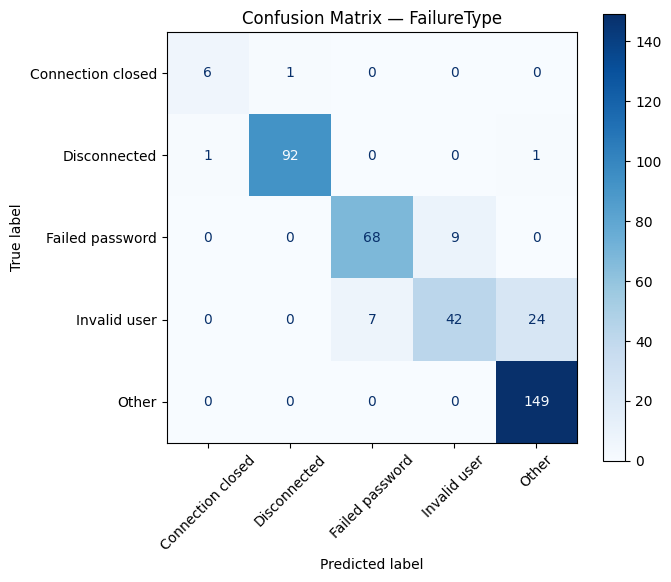

In [25]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# 1. Labels
def detect_failure_type(text):
    t = str(text).lower()
    if "invalid user" in t:      return "Invalid user"
    if "failed password" in t:   return "Failed password"
    if "connection closed" in t: return "Connection closed"
    if "disconnect" in t:        return "Disconnected"
    if "error" in t:             return "Other error"
    return "Other"

df["FailureType"] = df["Content"].apply(detect_failure_type) #creation de la colonne FailureType a partir de la colonne Content

num_cols = ["port", "Hour", "conn_per_hour"]
cat_cols = ["ip"] #on enleve user pour voir l'impact sur la performance
bool_cols = ["preauth"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("bool", "passthrough", bool_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols) #encodage
])

clf2 = Pipeline([
    ("preproc", preprocessor),
    ("svm", LinearSVC(max_iter=500))
])

X = df.drop(columns=["Content", "FailureType"]) #est il possible de predire FailureType a partir des autres colonnes?
y = df["FailureType"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

#matrice de confusion
fig, ax = plt.subplots(figsize=(7,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix — FailureType")
plt.tight_layout()
plt.show()


On a plus que la classe other qui a un recall de 100% ce qui rend notre model plus interressant a improuver

##GRID SEARCH

reprenons notre linear svm avec grid search pour essayer d'ameliorer notre model

Best params: {'svm__C': 1, 'svm__max_iter': 500}


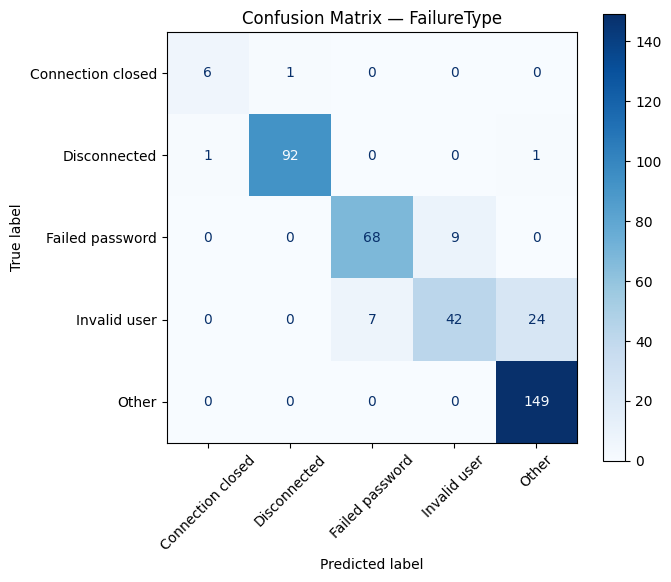

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("bool", "passthrough", bool_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols) #encodage
])

clf2 = Pipeline([
    ("preproc", preprocessor),
    ("svm", LinearSVC(max_iter=500))
])

X = df.drop(columns=["Content", "FailureType","user"]) 
y = df["FailureType"]



#hyperparamètres à tester
param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__max_iter": [500, 1000, 2000]
}

grid = GridSearchCV(
    clf2, 
    param_grid, 
    cv=5, 
    scoring="f1_macro", 
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Meilleure configuration
print("Best params:", grid.best_params_)

# Prédiction avec le meilleur modèle
y_pred = grid.predict(X_test)

# Matrice de confusion ---
fig, ax = plt.subplots(figsize=(7,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix — FailureType")
plt.tight_layout()
plt.show()


Le grid search n'a pas permis d'ameliorer notre model. Il peut y avoir plusieurs raisons:
-le dataset est petit, déséquilibré, et avec très peu de variété lexicale:
-Le modèle est déjà “en plateau” (meilleure performance deja atteinte) : il ne peut pas mieux apprendre que ce qui est présent dans les données

Améliorer l’algorithme ne change rien si l’information dans les données ne permet pas de mieux séparer les classes.

En effet la plupart des classes sont deja tres bien apprise, la seule qui a plus de mal est invalid user, qui est difficile a apprendre sans user


Essaions le grid search sur notre model de prediction de connexion type, pour voir si ce model peut etre amelioré


=== BEFORE GRID SEARCH ===
              precision    recall  f1-score   support

           N      0.943     0.902     0.922        92
           S      0.971     0.984     0.977       308

    accuracy                          0.965       400
   macro avg      0.957     0.943     0.950       400
weighted avg      0.965     0.965     0.965       400



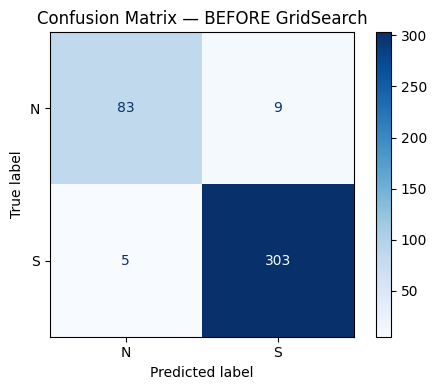


Best Params: {'LR__C': 0.1, 'LR__penalty': 'l2', 'LR__solver': 'lbfgs'}

=== AFTER GRID SEARCH ===
              precision    recall  f1-score   support

           N      1.000     0.815     0.898        92
           S      0.948     1.000     0.973       308

    accuracy                          0.958       400
   macro avg      0.974     0.908     0.936       400
weighted avg      0.960     0.958     0.956       400



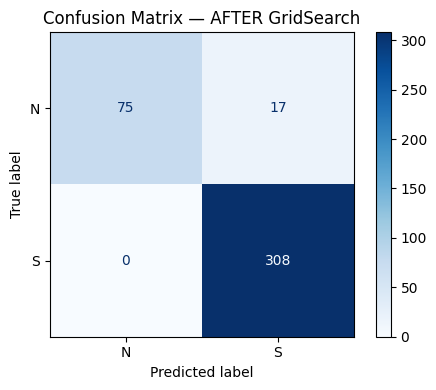

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# === Définition X / y ===
y_bin = df["connection_type"]
X_bin = df.drop(columns=["connection_type", "Content", "ip", "user"])

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]

# Préprocessing
prepro = ColumnTransformer([
    ("num",  "passthrough", num_cols),
    ("bool", "passthrough", bool_cols),
])

# Pipeline initial
pipe = Pipeline([
    ("prep", prepro),
    ("LR", LogisticRegression(max_iter=300))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.20, random_state=42, stratify=y_bin
)


# 1) — PERFORMANCE AVANT GRID SEARCH


pipe.fit(X_train, y_train)
y_pred_before = pipe.predict(X_test)

print("\n=== BEFORE GRID SEARCH ===")
print(classification_report(y_test, y_pred_before, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_before, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — BEFORE GridSearch")
plt.tight_layout()
plt.show()



# 2) — GRID SEARCH CV


param_grid = {
    "LR__C": [0.01, 0.1, 1, 10, 100],      # Régularisation
    "LR__penalty": ["l2"],                # (liblinear permet aussi l1 si tu veux tester)
    "LR__solver": ["lbfgs", "liblinear"]  # Meilleurs solveurs pour petit dataset
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)



# 3) — PERFORMANCE APRÈS GRID SEARCH


y_pred_after = grid.predict(X_test)

print("\n=== AFTER GRID SEARCH ===")
print(classification_report(y_test, y_pred_after, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_after, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — AFTER GridSearch")
plt.tight_layout()
plt.show()


Apres le grid search, on une baisse des performances pour la classe normale: plus que 75 vrai positifs contre 82 avant. La seule amelioration est pour le nombre de faux négatif qui est tomber a 0. Mais au globale on voit une baisse de la performance: de 14 erreurs a 17.

Le modèle optimisé par GridSearch :
devient plus sensible aux cas suspects (meilleur recall, FN=0), mais moins précis sur les cas normaux (plus de faux positifs)
Le model a été optimiser pour mieux detecter la classe suspecte mais au détriment de la classe normale


##applying ensemble model

pour commencer nous allons predire connection_type (plus interressant a ameliorer que notre model qui predit faillure), nous allons utiliser un Voting Classifier combinant plusieurs modèles de base. Chaque modèle de base est à son tour un BaggingClassifier, ce qui permet de réduire la variance. On combine donc la stabilité apportée par le Bagging et la force combinée de plusieurs modèles grâce au Voting.

=== Voting Classifier — connection_type ===
              precision    recall  f1-score   support

           N      0.943     0.902     0.922        92
           S      0.971     0.984     0.977       308

    accuracy                          0.965       400
   macro avg      0.957     0.943     0.950       400
weighted avg      0.965     0.965     0.965       400



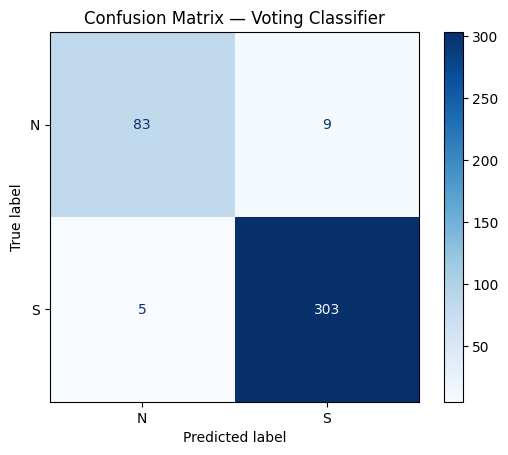

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Définition X / y ===
y = df["connection_type"]
X = df[["port", "preauth", "Hour", "conn_per_hour"]]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Colonnes par type
num_cols = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]


# Preprocessing
prepro = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("bool", "passthrough", bool_cols),
])

# Modèles de base avec Bagging
lr = BaggingClassifier(LogisticRegression(max_iter=300), n_estimators=10, random_state=42)
svm = BaggingClassifier(LinearSVC(max_iter=500), n_estimators=10, random_state=42)

# Voting Classifier
voting = Pipeline([
    ("prepro", prepro),
    ("voting", VotingClassifier(
        estimators=[("lr", lr), ("svm", svm)],
        voting="hard"  # pour classification binaire
    ))
])

# Entraînement
voting.fit(X_train, y_train)

# Prédiction
y_pred = voting.predict(X_test)

# Évaluation
print("=== Voting Classifier — connection_type ===")
print(classification_report(y_test, y_pred, digits=3))

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix — Voting Classifier")
plt.show()


On obtient les meme resultats qu'avec la regression linéaire car notre data set est plutot petit/ simple et les colonnes sont deja tres discriminantes, il est donc difficile d'obtenir de meilleurs resultats.
De plus LogisticRegression est déjà stable, donc faire du Bagging dessus n’améliore pas forcément la performance, juste la variance.